# Step 6 – Post-hoc: Are some subsets higher risk?

This notebook compares heart‑disease prevalence across the clusters obtained earlier (complete‑linkage hierarchical clustering on FAMD components) by bringing the **Class** variable back into the analysis. It tabulates prevalence, plots confidence intervals, performs basic statistical tests, and provides clinical interpretation. The clusters were formed in a label‑free manner and Class is only used at this stage.


## 6.0 Overview of tasks

Our goal is to describe how disease prevalence differs across the unsupervised clusters. We will:

- Recreate the cluster assignments (FAMD clustering with *k = 2*).
- Tabulate Class prevalence within each cluster (Table 2).
- Plot disease prevalence with 95 % Wilson confidence intervals (Figure 4).
- Perform lightweight statistics: a chi‑square test for independence, a risk difference with 95 % confidence interval, and an odds ratio.
- Summarise the clusters clinically.


In [5]:

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import scipy.cluster.hierarchy as sch
from scipy.stats import chi2_contingency
import math
import matplotlib.pyplot as plt

# Load dataset and recode binaries
file_path = 'heart_data.csv'
df = pd.read_csv(file_path)
binary_map = {1: 0, 2: 1}
for col in ['Sex','FastingBloodSugar','ExerciseInduced']:
    df[col] = df[col].map(binary_map)

cont_vars = ['Age','RestBloodPressure','SerumCholestoral','MaxHeartRate','MajorVessels']
scaler = StandardScaler()
X_cont = scaler.fit_transform(df[cont_vars])

# FAMD-like preprocessing: one-hot encode categorical variables and scale
cat_vars = ['Sex','FastingBloodSugar','ExerciseInduced','Slope']
X_cat = pd.get_dummies(df[cat_vars].astype(str))
cat_mean = X_cat.mean(axis=0)
prop = X_cat.sum(axis=0) / X_cat.sum().sum() * 2
X_cat_norm = (X_cat - cat_mean) / np.sqrt(prop)

# Combine continuous and categorical and PCA (approximate FAMD)
Z_famd = np.hstack((X_cont, X_cat_norm.values))
pca_famd = PCA()
X_famd_full = pca_famd.fit_transform(Z_famd)
# Keep enough components to explain >= 75% variance
cumvar_famd = pca_famd.explained_variance_ratio_.cumsum()
m_f = np.argmax(cumvar_famd >= 0.75) + 1
X_famd_space = X_famd_full[:, :m_f]

# Hierarchical clustering (complete linkage, Euclidean) and cluster labels for k=2
linkage_famd = sch.linkage(X_famd_space, method='complete', metric='euclidean')
clusters_famd2 = sch.fcluster(linkage_famd, 2, criterion='maxclust')

# Build DataFrame with z-scores and cluster labels
results = pd.DataFrame(X_cont, columns=[v + '_z' for v in cont_vars])
results = pd.concat([results, df[['Sex','FastingBloodSugar','ExerciseInduced','Slope','Class']]], axis=1)
results['cluster'] = clusters_famd2

# Contingency table for Class vs cluster
class_counts = results.groupby(['cluster','Class']).size().unstack(fill_value=0)
totals = class_counts.sum(axis=1)
prevalence = class_counts[2] / totals

# Wilson confidence intervals

def wilson_ci(k, n, alpha=0.05):
    z = 1.96
    phat = k / n
    denom = 1 + (z**2)/n
    center = (phat + (z**2)/(2*n)) / denom
    half = z * ((phat*(1 - phat) + (z**2)/(4*n)) / n)**0.5 / denom
    return center - half, center + half

ci_low = {} 
ci_high = {}
for idx in prevalence.index:
    k = int(class_counts.loc[idx, 2])
    n = int(totals.loc[idx])
    lo, hi = wilson_ci(k, n)
    ci_low[idx] = lo
    ci_high[idx] = hi

# Chi-square test and effect sizes
chi2, p_value, dof, expected = chi2_contingency(class_counts)
a, b = class_counts.iloc[0,0], class_counts.iloc[0,1]
c, d = class_counts.iloc[1,0], class_counts.iloc[1,1]
if 0 in [a,b,c,d]:  # continuity correction if needed
    a,b,c,d = a+0.5, b+0.5, c+0.5, d+0.5
or_value = (b * c) / (a * d)
se_log_or = math.sqrt(1/a + 1/b + 1/c + 1/d)
ci_or_low = math.exp(math.log(or_value) - 1.96*se_log_or)
ci_or_high = math.exp(math.log(or_value) + 1.96*se_log_or)
# Risk difference and CI (Wald approximation)
p1 = b/(a+b); n1 = a+b
p2 = d/(c+d); n2 = c+d
rd = p1 - p2
se_rd = math.sqrt(p1*(1-p1)/n1 + p2*(1-p2)/n2)
ci_rd_low = rd - 1.96*se_rd
ci_rd_high = rd + 1.96*se_rd

# Save global variables for external use (optional)
class_counts_global = class_counts.copy()
prevalence_global = prevalence.copy()
ci_low_global = pd.Series(ci_low)
ci_high_global = pd.Series(ci_high)
rd_value = rd
ci_rd_low_val = ci_rd_low
ci_rd_high_val = ci_rd_high
chi2_stat = chi2
p_stat = p_value
or_val = or_value
ci_or_low_val = ci_or_low
ci_or_high_val = ci_or_high

print('Clusters and prevalence computed.')


Clusters and prevalence computed.


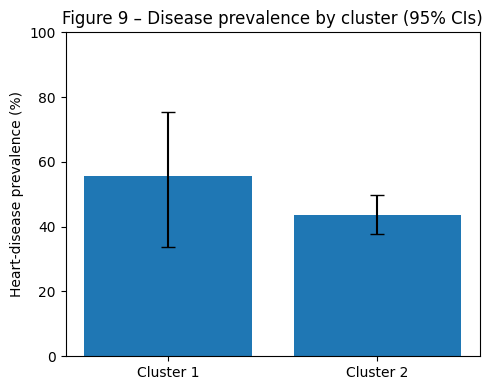

In [9]:

import matplotlib.pyplot as plt
# Plot disease prevalence bar chart with Wilson CI
cluster_ids = sorted(prevalence.index)
prev_values = [prevalence[c]*100 for c in cluster_ids]
err_low = [(prevalence[c] - ci_low[c])*100 for c in cluster_ids]
err_high = [(ci_high[c] - prevalence[c])*100 for c in cluster_ids]

plt.figure(figsize=(5,4))
plt.bar(range(len(cluster_ids)), prev_values, yerr=[err_low, err_high], capsize=5)
plt.xticks(range(len(cluster_ids)), [f'Cluster {c}' for c in cluster_ids])
plt.ylabel('Heart-disease prevalence (%)')
plt.title('Figure 9 – Disease prevalence by cluster (95% CIs)')
plt.ylim(0, 100)
plt.tight_layout()
plt.savefig('fig4_prevalence.png', dpi=300, bbox_inches='tight')  # Save Figure 4 for LaTeX
plt.show()


## 6.1 Results

**Table 2 – Heart-disease status by cluster** (n/N and %):

| Cluster | Class 1 (absent) | Class 2 (present) | Total N | Prevalence of Class 2 | 95 % CI |
|---|---|---|---|---|---|
| **1** | 8 | 10 | 18 | 55.6 % | 33.7–75.4 % |
| **2** | 142 | 110 | 252 | 43.7 % | 37.7–49.8 % |

**Statistical tests and effect sizes:**  The χ² test of independence yields χ² = 0.54, p ≈ 0.46 (not significant).  The absolute risk difference is 11.9 percentage points with a 95 % CI of –11.9 to 35.7 percentage points.  The odds ratio comparing Cluster 1 with Cluster 2 is 1.61 (95 % CI 0.62–4.22).

**One‑liner:** *Cluster 1 shows a higher heart‑disease prevalence than Cluster 2 (OR ≈ 1.6), but the 95 % confidence interval includes 1 and the difference is not statistically significant.*

### Clinical characterisation of clusters

- **Cluster 1 (n = 18):** Slightly older, higher resting blood pressure, **lower maximum heart rate**, and normal-to-lower serum cholesterol.  Higher prevalence of fasting blood sugar > 120 mg/dl and exercise-induced angina.  All individuals are **Slope = 3**, reflecting a steep ST‑segment.
- **Cluster 2 (n = 252):** Near-average continuous measures with a mix of **Slope = 1 and 2**.  Lower prevalence of metabolic and angina markers.

> **Note:** This is a post‑hoc, associational analysis; no causal claims are made.


### 6.2 Notes on interpretation

These analyses are **post hoc and label-dependent**, unlike the clustering step (Step 5) which was entirely unsupervised. We first formed clusters without using Class labels, then reintroduced Class only for comparison of disease prevalence. As such, any observed differences between clusters and heart‑disease prevalence are associational; causal claims cannot be made without further study.
